# Transfer Learning with TensorFlow Part2: Fine Tuning

In [ ]:
# !nvidia-smi
import tensorflow as tf

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however it is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).

We've done this for some functions we've used before here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-06 09:07:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-06 09:07:46 (79.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook

from helper_functions import *

## Let's get some images(data) and turn images to tensors

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of the training set from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-12-06 09:07:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   154MB/s    in 1.0s    

2021-12-06 09:07:49 (154 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Unzipping the data
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images & directories are there in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_per

In [ ]:
import os
class_names = os.listdir("/content/10_food_classes_10_percent/train")
class_names

['sushi',
 'steak',
 'chicken_curry',
 'hamburger',
 'fried_rice',
 'pizza',
 'grilled_salmon',
 'ramen',
 'chicken_wings',
 'ice_cream']

In [ ]:
# Create training and testing paths
train_dir = "/content/10_food_classes_10_percent/test"
test_dir = "/content/10_food_classes_10_percent/train"

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


### NOTE: We are not using ImageDataGenerator here as we did in the previous notebooks. Instead, we're using image_dataset_from_directory() which generates tf.data.Dataset 


In [ ]:
type(train_data_10_percent), train_data_10_percent.take(1)

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 <TakeDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>)

In [ ]:
# train_data_10_percent
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.21426392e+00 1.21426392e+00 1.21426392e+00]
   [4.03069645e-01 4.03069645e-01 4.03069645e-01]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.33166504e+00 1.33166504e+00 1.33166504e+00]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]]

  ...

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1

# Model 0: Building a transfer learning Feature Extraction model using Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order. 

But the Functional APi gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1.Create model using tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  
# In Feature extraction, we do not change the bottom layers, we only change the top layers

# 2.Freeze the base model (so that the underlying pre-trained patterns aren't updated during the training)
base_model.trainable = False

# 3. Create Inputs to our model
inputs = tf.keras.layers.Input(shape=(224,224, 3), name="input_layer")

# 4.If using a model like ResNet50V2 you will need to normalize the inputs (you don't have to for EfficientNetx)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5.Pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs thourgh base model: {x.shape}")

# 6.Average Pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f"Shape after global average pooling 2D: {x.shape}")

# 7.Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="outpu_layer")(x)

# 8.Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

# 9.Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10.Fit the data
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extraction")]
                                 )

Shape after passing inputs thourgh base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211206-090828
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


79/79 [==============================] - 23s 175ms/step - loss: 1.2356 - accuracy: 0.6648 - val_loss: 0.7533 - val_accuracy: 0.8281
Epoch 2/5
79/79 [==============================] - 13s 163ms/step - loss: 0.5787 - accuracy: 0.8480 - val_loss: 0.5806 - val_accuracy: 0.8438
Epoch 3/5
79/79 [==============================] - 13s 162ms/step - loss: 0.4438 - accuracy: 0.8780 - val_loss: 0.5427 - val_accuracy: 0.8438
Epoch 4/5
79/79 [==============================] - 12s 147ms/step - loss: 0.3795 - accuracy: 0.8952 - val_loss: 0.4574 - val_accuracy: 0.8542
Epoch 5/5
79/79 [==============================] - 13s 164ms/step - loss: 0.3316 - accuracy: 0.9112 - val_loss: 0.4874 - val_accuracy: 0.8385


In [ ]:
model_0.evaluate(test_data)

24/24 [==============================] - 4s 158ms/step - loss: 0.5426 - accuracy: 0.8347


[0.5426497459411621, 0.8346666693687439]

In [ ]:
# let's check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)
# see layer no.1 & 2, rescaling & normalization already available

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

#### EfficientNetx models in tf.keras.applications have an in-built rescaling & normalizing layer

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 outpu_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


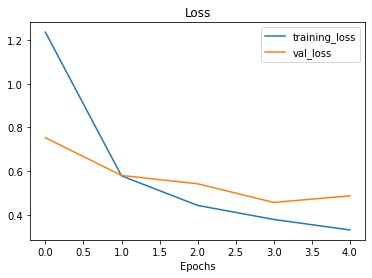

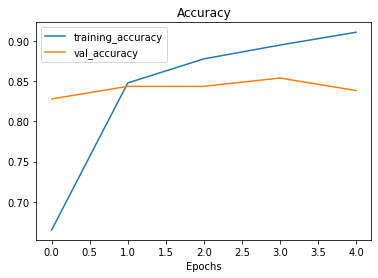

In [ ]:
plot_loss_curves(history_10_percent)

# In Part 1 we performed Transfer learning using ***Tensorflow Hub*** & this time we have used ***Tensorflow Keras Functional APIs***. Which one to use depends on the use case in hand. Tensorflow Functional APIs helps in building more customized models.

# Getting a feature vector(Learned representation of data) from a trained model

Let's demonstrate the GlobalAveragePooling 2D layer...

We have a tensor of shape (None, 7, 7, 1280) after our inputs/model_0 goes through `base_model`...

But then when it passes through GlobalAveragePooling2D, it truns into (None, 1280).

Let's use a similar shaped tensor of shape (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.(it tranforms a 4D tensor to 2D tensor)


In [ ]:
# Define input shape
input_shape = (1,4,4,3)

# create random tensor & set random seed
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random tensor:\n {input_tensor}\n")

# pass it through GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled tensor:{global_average_pooled_tensor.shape}")
print(f"Global Average Pooled tensor:\n {global_average_pooled_tensor}\n")  # Input turned into Feature Vector

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled tensor:(1, 3)
Global Average Pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [ ]:
# we can replicate global average pooling layer functionality as follows
print("tf.reduce_mean tensor:",tf.reduce_mean(input_tensor=input_tensor, axis=[1,2]))
print(f"Gloabl average pooled tensor: {global_average_pooled_tensor}")

tf.reduce_mean tensor: tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)
Gloabl average pooled tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [ ]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Gloabl Max pooled tensor: {global_max_pooled_tensor}")

Gloabl Max pooled tensor: [[0.9058464 1.1603122 1.6994323]]


In [ ]:
tf.reduce_max(input_tensor, axis=[1,2]) # same as above

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

🛠 Practice: Do the same as the above cell but for tf.keras.layers.GlobalMaxPool2D().

## **NOTE**: There is a weights matrix for every input sample & a bias vector for every neuron

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data. How about we set up a bunch of experiments to find out:
> 1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation.
> 2. `model_2` - Use feature extraction transfer learning with 10% of the training data with augmentation.
> 3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with augmentation
> 4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with augmentation

✅NOTE: Throughout the experiments the same test dataset will be used to evaluate the models..this ensure consistency across evaluation metrics.

In [ ]:
import tensorflow as tf

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2021-12-06 09:12:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   143MB/s    in 0.9s    

2021-12-06 09:12:04 (143 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

### Create training & test directories

In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

### Loading our images as tf.data.Datasets

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE
                                                                           )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into our model

see documentation: https://www.tensorflow.org/tutorials/images/data_augmentation
Previously we've used the different parameters of the ImageDataGenerator class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the tf.keras.layers.experimental.preprocessing module and creating a dedicated data augmentation layer.


> Indented block



This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations , zooms
data_augmentation = tf.keras.Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        # preprocessing.Rescaling(1./255) # keep for RestNet50V2,  remove for EfficientNetB0
], name="data_augmentation")

### Let's visualize how an image will look like after data augmention

(-0.5, 307.5, 602.5, -0.5)

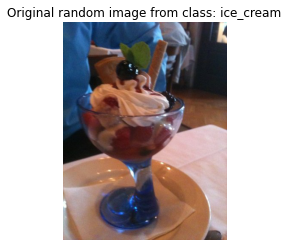

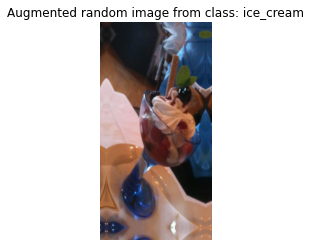

In [ ]:
# view a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)  # choose a random class
target_dir = "10_food_classes_1_percent/train/"+ target_class   # get the class path
random_image_path = target_dir + "/" + random.choice(os.listdir(target_dir))    # pick up a random image from the class path

img = mpimg.imread(random_image_path)   # read the image 
plt.imshow(img)
plt.title(label=f"Original random image from class: {target_class}")
plt.axis(False)

plt.figure()
augmented_img = data_augmentation(img)
plt.imshow(augmented_img/255.)           # normalizing the image
plt.title(label=f"Augmented random image from class: {target_class}")
plt.axis(False)

# Model 1: Feature extraction transfer learning on 1% data with data augmentation

In [ ]:
# Setup the input shape & base model, freezing the base model layers
input_shape = (224, 224, 3)

# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# add data augmentation sequential layer
x = data_augmentation(inputs)

# give base model the inputa after they have been augmented and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# create a modelusing the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])




Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211206-091221
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 16s 4s/step - loss: 2.4396 - accuracy: 0.1571 - val_loss: 2.2510 - val_accuracy: 0.1612
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1672 - accuracy: 0.1571 - val_loss: 2.1329 - val_accuracy: 0.2270
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.0201 - accuracy: 0.3143 - val_loss: 2.0293 - val_accuracy: 0.2780
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8448 - accuracy: 0.5000 - val_loss: 1.9320 - val_accuracy: 0.3586
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6542 - accuracy: 0.6286 - val_loss: 1.8573 - val_accuracy: 0.4293


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# evaluate on full test d
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 1.8426 - accuracy: 0.4236


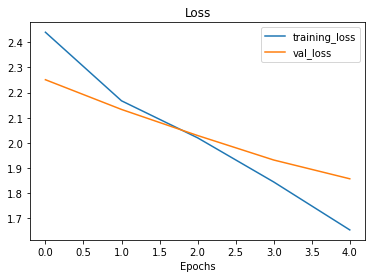

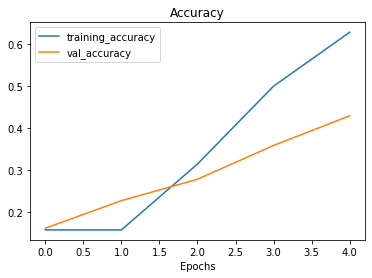

In [ ]:
 # How does the model with 1 percent data & loss curves look like?
 plot_loss_curves(history_1_percent)

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Create model checkpoint callback


In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211206-091407
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


79/79 [==============================] - ETA: 0s - loss: 1.4208 - accuracy: 0.5852WARNING:tensorflow:Model was constructed with shape (512, 384, 3) for input KerasTensor(type_spec=TensorSpec(shape=(512, 384, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 52s 554ms/step - loss: 1.4208 - accuracy: 0.5852 - val_loss: 0.7879 - val_accuracy: 0.8125
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.7753 - accuracy: 0.7820
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 36s 452ms/step - loss: 0.7753 - accuracy: 0.7820 - val_loss: 0.5539 - val_accuracy: 0.8388
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 

In [ ]:
results_10_percent_data_aug= model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.3660 - accuracy: 0.8948


In [ ]:
plot_loss_curves(history_10_percent_data_aug)

In [ ]:
model_2.load_weights(filepath=checkpoint_path)
loaded_weights_model_result = model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.3660 - accuracy: 0.8948


In [ ]:
# results_10_percent_data_aug == loaded_weights_model_result

In [ ]:
# results_10_percent_data_aug

In [ ]:
loaded_weights_model_result

[0.3660050928592682, 0.8948000073432922]

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_result))

array([ True,  True])

In [ ]:
print(np.array(results_10_percent_data_aug)- np.array(loaded_weights_model_result))

[2.98023224e-08 0.00000000e+00]
[2.98023224e-08 0.00000000e+00]


# Model 3: Fine tuning an existing model on 10% of the data

🔑**NOTE**: Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

Herewe  are basically performing fine tuning on model 2 on which we have already performed feature extraction for 5 epochs.


In [ ]:
# layers in our loaded model
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Let's check which layers in model_2 are trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7487ecccd0> True
<keras.engine.sequential.Sequential object at 0x7f74f76d7690> True
<keras.engine.functional.Functional object at 0x7f74879b7d10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f7487d62890> True
<keras.layers.core.dense.Dense object at 0x7f7487e06b10> True


In [ ]:
# Now, let's check which layers in model_2's non-trainable layer(ie. base model) are trainable
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables in base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
for i, layer in enumerate(base_model.layers[-10:]):
  print(i, " ", layer.name, " ", layer.trainable)

0   block7a_se_squeeze   False
1   block7a_se_reshape   False
2   block7a_se_reduce   False
3   block7a_se_expand   False
4   block7a_se_excite   False
5   block7a_project_conv   False
6   block7a_project_bn   False
7   top_conv   False
8   top_bn   False
9   top_activation   False


In [ ]:
# To begin Fine-tuning, let's start by setting top 10 layers of our base model.trainable = True

base_model.trainable = True  # Set all layers to trainable = True

for layer in base_model.layers[:-10]:  # Set all layers to layer.trainable = False except the last 10 layers
  layer.trainable = False

# OR instead of above you could also do the following
# for i, layer in enumerate(base_model.layers[-10:]):
  # layer.trainable = True

# Anytime you chane the parameters of a model you need to recompile that model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # we don't want the weight of the top 10 layers to get updated to a great extent
                # When fine-tuning, you typically want ot lower the learning by 10x
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### NOTE: We usually keep the lower layers frozen since they learn bigger features and we want the top layers to better learn on custom data.

>🔑**NOTE**: When fine-tuning , it's best practice to lower your learning rate bt some amount. How much? This is a hyper-parameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim other values).

>*A good resource for this is the UMLFit paper.*

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers[-10:]):
  print(i, " ", layer.name, " ", layer.trainable)

0   block7a_se_squeeze   True
1   block7a_se_reshape   True
2   block7a_se_reduce   True
3   block7a_se_expand   True
4   block7a_se_excite   True
5   block7a_project_conv   True
6   block7a_project_bn   True
7   top_conv   True
8   top_bn   True
9   top_activation   True


In [ ]:
print(len(model_2.trainable_variables))

12


## Fitting our fine-tuned model 2 on training set

In [ ]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model 2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # start training from previous last epoch
                                               validation_steps=int(0.25* len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211206-092340
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


79/79 [==============================] - 42s 431ms/step - loss: 0.4318 - accuracy: 0.8624 - val_loss: 0.3115 - val_accuracy: 0.8849
Epoch 6/10
79/79 [==============================] - 31s 380ms/step - loss: 0.3695 - accuracy: 0.8768 - val_loss: 0.2703 - val_accuracy: 0.9062
Epoch 7/10
79/79 [==============================] - 28s 354ms/step - loss: 0.3384 - accuracy: 0.8864 - val_loss: 0.2505 - val_accuracy: 0.9161
Epoch 8/10
79/79 [==============================] - 29s 360ms/step - loss: 0.3013 - accuracy: 0.8992 - val_loss: 0.2239 - val_accuracy: 0.9243
Epoch 9/10
79/79 [==============================] - 28s 342ms/step - loss: 0.2780 - accuracy: 0.9088 - val_loss: 0.2117 - val_accuracy: 0.9276
Epoch 10/10
79/79 [==============================] - 28s 348ms/step - loss: 0.2429 - accuracy: 0.9172 - val_loss: 0.2184 - val_accuracy: 0.9178


In [ ]:
results_fine_tune_10_percent =   model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.1990 - accuracy: 0.9324


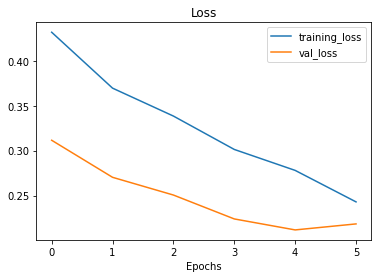

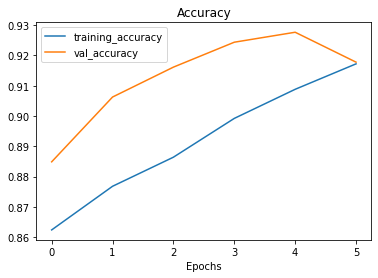

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# Let's create a function that compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.5852000117301941, 0.7820000052452087, 0.8172000050544739, 0.8447999954223633, 0.8460000157356262, 0.8623999953269958, 0.876800000667572, 0.8863999843597412, 0.8992000222206116, 0.9088000059127808, 0.9172000288963318]


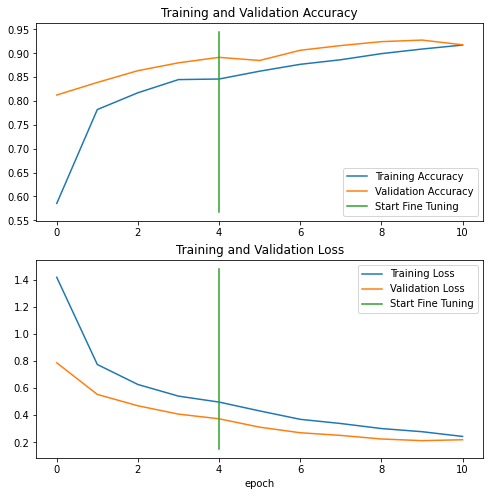

In [ ]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug)

# Model 4: Fine tuning + data augmentation + all data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-12-06 09:34:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   180MB/s    in 2.7s    

2021-12-06 09:34:07 (180 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_dir_all_data = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_all_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE,
                                                                     batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model 2 (this is the fine tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.1990 - accuracy: 0.9324


[0.19901423156261444, 0.9323999881744385]

In [ ]:
results_fine_tune_10_percent

[0.19901421666145325, 0.9323999881744385]

### We want to revert our model_2 to its feature extraction version. (As per our workflow: first train a model with feature extraction for few initial epochs followed by next few epochs for  fine tuning.)

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the
# same stage the 10 percent data model was fine-tuned from. 

model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.3660 - accuracy: 0.8948


[0.3660050332546234, 0.8948000073432922]

Alright, the previous steps might seem quite confusing but all we've done is:

> Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.

> Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.

> Saved the results and training logs each time.

> Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [ ]:
# check which layers are trainable
for layer_no, layer in enumerate(model_2.layers):
  print(layer_no, ": ", layer.name," ", layer.trainable)

0 :  input_layer   True
1 :  data_augmentation   True
2 :  efficientnetb0   True
3 :  global_average_pooling_layer   True
4 :  output_layer   True


In [ ]:
for layer_no, layer in enumerate(model_2.layers[2].layers[-11:]):  
  print(layer_no,": ",layer.name, " ", layer.trainable)
  # we had already set the top 10 layers of the base model to trainable for fine tuning

0 :  block7a_activation   False
1 :  block7a_se_squeeze   True
2 :  block7a_se_reshape   True
3 :  block7a_se_reduce   True
4 :  block7a_se_expand   True
5 :  block7a_se_excite   True
6 :  block7a_project_conv   True
7 :  block7a_project_bn   True
8 :  top_conv   True
9 :  top_bn   True
10 :  top_activation   True


In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
# continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_all_data = model_2.fit(train_all_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps=int(0.25*len(test_data)),
                                    initial_epoch=history_10_percent_data_aug.epoch[-1],
                                    callbacks=[create_tensorboard_callback("transfer_learning","full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211206-103804
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 82s 316ms/step - loss: 0.6474 - accuracy: 0.7912 - val_loss: 0.3460 - val_accuracy: 0.8865
Epoch 6/10
235/235 [==============================] - 72s 303ms/step - loss: 0.5586 - accuracy: 0.8227 - val_loss: 0.3441 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 68s 288ms/step - loss: 0.4971 - accuracy: 0.8397 - val_loss: 0.3320 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 66s 280ms/step - loss: 0.4471 - accuracy: 0.8573 - val_loss: 0.2959 - val_accuracy: 0.8832
Epoch 9/10
235/235 [==============================] - 62s 261ms/step - loss: 0.4173 - accuracy: 0.8621 - val_loss: 0.2908 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 62s 263ms/step - loss: 0.3828 - accuracy: 0.8792 - val_loss: 0.2788 - val_accuracy: 0.9112


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.2608 - accuracy: 0.9160


[0.26080283522605896, 0.9160000085830688]

5
11
[0.5852000117301941, 0.7820000052452087, 0.8172000050544739, 0.8447999954223633, 0.8460000157356262, 0.7911999821662903, 0.8226666450500488, 0.839733362197876, 0.8573333621025085, 0.8621333241462708, 0.8791999816894531]


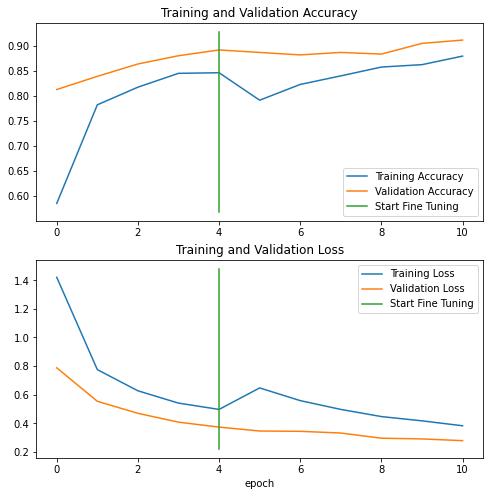

In [ ]:
compare_historys(history_10_percent_data_aug, history_fine_all_data)

# Comparing aur modelling experiment results in Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer learning experiments with 10 Food101 Classes" \
 --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning."\
 --one_shot # exits the uploader once it finishes uploading


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=p3wcJJJA6CFSMK9u70zcbcADYGzp9H&prompt=consent&access_type=o

# My tensorboard experminets are available at :  https://tensorboard.dev/experiment/I7pDf8zTRaykT9vXwCB05w/

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/I7pDf8zTRaykT9vXwCB05w/
	Name                 Transfer learning experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   I7pDf8zTRaykT9vXwCB05w
	Created              2021-12-06 11:15:30 (14 minutes ago)
	Updated              2021-12-06 11:15:38 (13 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              234
	Tensor bytes         0
	Binary object bytes  6647227
https://tensorboard.dev/experiment/YbL5BYL3TqC5EV6fliPW2A/
	Name                 EfficientNetB0 Vs ResNet50V2 (SAK_1193)
	Description          Comparing two TF Hub feature etraction model architectures using 10% of training data
	Id                   YbL5BYL3TqC5EV6fliPW2A
	Created              2021-09-28 09:09:51
	Updated              2021-09-28 09:09:55
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         

In [ ]:
! tensorboard dev delete --experiment_id I7pDf8zTRaykT9vXwCB05w

Deleted experiment I7pDf8zTRaykT9vXwCB05w.
